# 매직스플릿 20 종목 포트폴리오최적화 백테스팅

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import concurrent.futures

class Position:
    def __init__(self, buy_price, quantity,order,additional_buy_drop_rate,sell_profit_rate):
        self.buy_price = buy_price
        self.quantity = quantity
        self.order = order  # 포지션의 차수
        self.additional_buy_drop_rate = additional_buy_drop_rate  # 추가 매수 드랍 비율 추가
        self.sell_profit_rate = sell_profit_rate  # 매도 수익률 추가

def rolling_window_calculations(df):
    window_size = max(int(len(df) * 2 / 3), 1)  # 윈도우 크기를 정수형으로 설정, 최소값은 1
    window_size = min(window_size, 5 * 252)  # 윈도우 크기가 5년치를 넘지 않도록 설정
    min_periods = min(window_size, 252)  # 최소 기간 설정

    df = df.copy()
    df = df[df['PBR'] != 0]
    # df = df[df['종가'] != 0]
    df['five_year_high'] = df['고가'].rolling(window=window_size, min_periods=min_periods).max()
    df['five_year_low'] = df['종가'].rolling(window=window_size, min_periods=min_periods).min()
    df['normalized_price'] = (df['종가'] - df['five_year_low']) / (df['five_year_high'] - df['five_year_low']) * 100 # 진입시기결정

    df.loc[:, 'five_year_avg_pbr'] = df['PBR'].rolling(window=window_size, min_periods=min_periods).mean()
    df = df.dropna(subset=['five_year_avg_pbr'])

    return df

def check_buy_sell_conditions(row, positions, capital, investment_per_split, num_splits, buy_threshold, buy_signals, sell_signals,code):
    normalized = row['normalized_price']
    # print(normalized)
    current_pbr = row['PBR']
    avg_pbr = row['five_year_avg_pbr'] # 5년 평균 PBR
    five_year_low = row['five_year_low']
    current_order = len(positions) + 1  # 현재 매수할 포지션의 차수, 수정해야할듯 

    # 변수 초기화
    additional_buy_drop_rate = 0
    sell_profit_rate = 0  # 초기화
    
    # print(f'investment_per_split:{investment_per_split}')
     # 1차 진입 조건: normalized 가격이 buy_threshold보다 낮고 아직 매수하지 않았을 때
    if normalized < buy_threshold and len(positions) == 0:
        if capital >= investment_per_split:
            #차수별 수익률 계산 
            additional_buy_drop_rate = calculate_additional_buy_drop_rate(row['종가'], five_year_low, num_splits)
            # 매도 수익률 계산
            sell_profit_rate = calculate_sell_profit_rate(additional_buy_drop_rate)
            # print(buy_threshold,additional_buy_drop_rate,sell_profit_rate)
            # 종가, 수량 , 차수
            new_position = Position(row['종가'], int(investment_per_split / row['종가']), 1 ,sell_profit_rate, additional_buy_drop_rate)
            positions.append(new_position)
            capital -= row['종가']*int(investment_per_split / row['종가'])
            # print(f'샀어1조건 현금은:{capital}', f'{row.name} 매입금액:{investment_per_split} 종가:{row["종가"]} 차수별수익률:{additional_buy_drop_rate}')
            # row.name은 현재 행의 인덱스 (날짜)를 반환합니다. # 매수 시점 기록
            buy_signals.append((row.name, row['종가']))
    
     # 추가 매수 조건: 이미 매수했고, 현재 가격이 이전 매수 가격보다 더 낮아졌을 때
    elif positions and len(positions) < num_splits and capital >= investment_per_split:
        last_position = positions[-1]  # 마지막 포지션(가장 최근 매수)
        if row['종가'] <= positions[-1].buy_price * (1 - last_position.additional_buy_drop_rate):
            new_position = Position(row['종가'], int(investment_per_split / row['종가']), len(positions) + 1,last_position.sell_profit_rate, last_position.additional_buy_drop_rate)
            positions.append(new_position)
            capital -= row['종가']*int(investment_per_split / row['종가'])
            # print(f'샀어2조건 현금은:{capital}', f'{row.name} 매입금액:{investment_per_split} 종가:{row["종가"]},차수별수익률:{last_position.additional_buy_drop_rate}')
            buy_signals.append((row.name, row['종가']))

   

    # Sell condition for orders 2nd to 10th
    for position in positions:
        if row['종가'] >= position.buy_price * (1 + position.sell_profit_rate ) and position.order > 1:  # 2차이면서 매수가보다 일정비율이상되면
            # print(f'매수단가: {position.buy_price} sell_profit_rate:{position.sell_profit_rate}') 
            capital += position.quantity * row['종가']
            positions.remove(position)
            sell_signals.append((row.name, row['종가'])) # 매도신호(날짜,단가) 저장
            
            # print(f'2~10차 팔았어 현금은: {capital} ,{row.name}, 종가:{row["종가"]}') 
    
    # 청산된 종목 확인을 위한 변수
    liquidated = False
    
    # Final sell signal (liquidation) for 1st order 청산
    for position in positions:
        if current_pbr >= avg_pbr and row['종가'] >= position.buy_price * (1 + position.sell_profit_rate ) and position.order == 1:
            capital += position.quantity * row['종가']
            # print(f'청산 완료 현금은: {capital}') 
            positions.remove(position)
            sell_signals.append((row.name, row['종가']))
    # print(f'이날짜 현금은 결국 : {capital},{row.name}')
            liquidated = True

    # 청산된 경우 종목 코드 반환
    if liquidated and not positions:
        return positions, capital, code
    else:
        return positions, capital, None
    

def calculate_additional_buy_drop_rate(last_buy_price, five_year_low, num_splits):
    return 1 - (( five_year_low/ last_buy_price) ** (1 / (num_splits - 1)))

def calculate_sell_profit_rate(buy_profit_rate):
    """
    매수 수익률을 기반으로 매도 수익률을 계산합니다.
    :param buy_profit_rate: 매수 기준 수익률
    :return: 계산된 매도 수익률
    """
    sell_profit_rate = (1 / (1 - buy_profit_rate)) - 1
    return sell_profit_rate 
    
def update_portfolio_values(positions, capital):
    portfolio_value = capital + sum(position.quantity * position.buy_price for position in positions)
    return portfolio_value

def calculate_final_results(initial_capital, final_capital, total_days):
    total_profit = final_capital  - initial_capital
    return_on_investment = (total_profit / initial_capital) * 100
    total_years = total_days / 365.25
     # 예외 처리: 자본이 0 이하인 경우 CAGR 계산 방지
    if final_capital <= 0:
        cagr = -1  # 자본이 완전히 손실된 것으로 간주, CAGR을 -100%로 설정
    else:
        cagr = ((final_capital / initial_capital) ** (1 / total_years)) - 1

    return total_profit, return_on_investment, cagr #총수익률, ROI, 연환산수익률
    
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# 클래스 및 함수 정의 (위에서 제공된 단일 종목 백테스팅 관련 코드 사용)
def get_trading_dates(stock_data):
    # Aggregate all dates from each stock's data
    all_dates = set()
    for code, data in stock_data.items():
        all_dates.update(data.index)

    # Sort dates and return as a list
    return sorted(list(all_dates))

def load_all_stock_data(stock_codes):
    stock_data = {}
    for code in stock_codes:
        df = pd.read_excel(f'./korea_stock/{code}.xlsx')
        df['날짜'] = pd.to_datetime(df['날짜'])
        df.set_index('날짜', inplace=True)
         # 데이터 전처리
        df = rolling_window_calculations(df)
        stock_data[code] = df
    print(f'{code} done')
    return stock_data
def get_data_for_period(stock_data, start_year=2009, end_year=2023):
    period_data = {}
    for code, data in stock_data.items():
        start_date = pd.Timestamp(year=start_year, month=1, day=1)
        end_date = pd.Timestamp(year=end_year, month=12, day=31)
        period_data[code] = data[(data.index >= start_date) & (data.index <= end_date)]
    return period_data
def portfolio_backtesting(stock_codes, initial_capital, num_splits, investment_ratio,buy_threshold,stock_data):
    total_portfolio_value = initial_capital
    capital = initial_capital  # capital을 초기 자본으로 초기화
    positions_dict = {code: [] for code in stock_codes}  # 각 종목별 포지션 리스트를 위한 딕셔너리
    positions = []  # 전체 포트폴리오의 포지션
    buy_signals = []  # 매수 신호를 기록하는 리스트
    sell_signals = []  # 매도 신호를 기록하는 리스트
    portfolio_values_over_time = []
    capital_over_time = []  # 자본 변화 추적을 위한 리스트 초기화

    # 추가: 진입된 종목과 그들의 현재 최대 차수를 추적하기 위한 딕셔너리
    entered_stocks = set()  # 진입된 종목을 추적하는 집합
    current_orders_dict = {}  # 종목별 현재 차수를 추적하는 딕셔너리
       
    # print(all_trading_dates)
    previous_month = None
    
    all_trading_dates = get_trading_dates(stock_data)    
   
    # 백테스팅 실행
    for date_str  in all_trading_dates:
        # print(date_str)
        date = pd.to_datetime(date_str)# 날짜 문자열을 datetime 객체로 변환
        
        current_month = date.month
        # 새로운 달의 시작일 경우, investment_per_split 업데이트
        if current_month != previous_month:
            investment_per_split = total_portfolio_value * investment_ratio // num_splits
            # print(f'investment_per_split:{investment_per_split},total_portfolio_value : {total_portfolio_value}, investment_ratio : {investment_ratio},num_splits : {num_splits}')
            previous_month = current_month
        for code in stock_codes:
            if date in stock_data[code].index:
                row = stock_data[code].loc[date]

                if len(entered_stocks) < 7 or code in entered_stocks: # 종목수 제한 
                    positions = positions_dict[code]  # 현재 종목의 포지션 리스트
                    # print(f'종목코드{code}')
                    positions, capital ,liquidated_code = check_buy_sell_conditions(row, positions, capital, investment_per_split, num_splits, buy_threshold, buy_signals, sell_signals,code)
                    positions_dict[code] = positions  # 업데이트된 포지션 리스트를 다시 딕셔너리에 저장
                    # print('여긴가')
                    # 추가: 진입된 종목과 그들의 현재 최대 차수 업데이트
                    if positions:  # 해당 종목에 포지션이 있으면
                        entered_stocks.add(code)
                        current_order = max(position.order for position in positions)
                        current_orders_dict[code] = current_order
                    # 청산된 종목 제거
                    if liquidated_code:
                        entered_stocks.discard(liquidated_code)
                        if liquidated_code in current_orders_dict:
                            del current_orders_dict[liquidated_code]
        # 포트폴리오 가치 업데이트
        current_stock_value = 0
        for code in stock_codes:
            for position in positions_dict[code]:
                current_stock_value += position.quantity * position.buy_price
        total_portfolio_value = capital + current_stock_value
        # print(f'현금:{capital},주식가격{current_stock_value},포트폴리오가격{total_portfolio_value}')
        portfolio_values_over_time.append(total_portfolio_value)
        capital_over_time.append(capital)  # 현재 자본 추가
        # print(f"1차로 진입된 종목 개수: {len(entered_stocks)}")
        # for code, order in current_orders_dict.items():
            # print(f"종목 코드 {code}의 현재 최대 차수: {order}")
     # 백테스팅 루프 종료 후
    total_days = (all_trading_dates[-1] - all_trading_dates[0]).days
    total_years = total_days / 365.25
    final_portfolio_value = portfolio_values_over_time[-1]
    cagr = ((final_portfolio_value / initial_capital) ** (1 / total_years)) - 1
        
    return positions_dict, total_portfolio_value, portfolio_values_over_time, capital_over_time, buy_signals, sell_signals, all_trading_dates, cagr

    


def backtesting_wrapper(params):
    num_splits, buy_threshold, investment_ratio = params
    try:
        # print(f'Starting: num_splits={num_splits}, buy_threshold={buy_threshold}, investment_ratio={investment_ratio}')
        _, _, _, _, _, _, _, cagr = portfolio_backtesting(stock_codes, initial_capital, num_splits, investment_ratio, buy_threshold, stock_data)
        # print(f'Completed: num_splits={num_splits}, buy_threshold={buy_threshold}, investment_ratio={investment_ratio}, CAGR={cagr}')
        return num_splits, buy_threshold, investment_ratio, cagr
    except Exception as e:
        print(f'Error in backtesting: {e}')
        return num_splits, buy_threshold, investment_ratio, None  # 오류가 발생한 경우 CAGR을 None으로 설정

def check_if_already_calculated(num_splits, buy_threshold, investment_ratio):
    if os.path.exists(results_file):
        existing_results = pd.read_csv(results_file)
        return any((existing_results['num_splits'] == num_splits) & 
                   (existing_results['buy_threshold'] == buy_threshold) &
                   (existing_results['investment_ratio'] == investment_ratio))
    return False
    
def run_backtesting_for_period(stock_codes, initial_capital, num_splits, investment_ratio, buy_threshold, start_year, end_year, loaded_stock_data):
    # 주어진 기간에 대한 데이터 로드
    period_stock_data = get_data_for_period(loaded_stock_data, start_year, end_year)
    
    # 백테스팅 수행
    _, total_portfolio_value, _, _, _, _, _, cagr = portfolio_backtesting(
        stock_codes, initial_capital, num_splits, investment_ratio, buy_threshold, loaded_stock_data)
    
    return total_portfolio_value, cagr

def calculate_average_results(backtesting_results):
    total_values = [result[0] for result in backtesting_results]
    cagr_values = [result[1] for result in backtesting_results]

    average_total_value = sum(total_values) / len(total_values)
    average_cagr = sum(cagr_values) / len(cagr_values)

    return average_total_value, average_cagr

# 시간 기간에 따른 평균 CAGR을 계산하는 래퍼 함수
def average_cagr_wrapper(params):
    num_splits, buy_threshold, investment_ratio = params
    period_results = []
    for start_year, end_year in time_periods:
        try:
            total_value, cagr = run_backtesting_for_period(
                stock_codes, initial_capital, num_splits, investment_ratio, buy_threshold, start_year, end_year,stock_data)
            period_results.append((total_value, cagr))
            print(f'기간 하나 완료{params}')
        except Exception as e:
            print(f'Error in backtesting for period {start_year}-{end_year}: {e}')
            period_results.append((0, None))  # 오류가 발생한 경우 결과를 (0, None)으로 설정

    average_results = calculate_average_results(period_results)
    return num_splits, buy_threshold, investment_ratio, average_results[0], average_results[1]

# 포트폴리오 백테스팅 실행
stock_codes = [ 
#                '021240',  
#               '037710',
#                '010420',
#                 '016920',
# '021240',
# '032750',
# '037400',
# '037710',
# # '039740',
# '045060',
#             '075130',
#             '088790',
#             '094970',
#             '136540',
#             # '225590',
#             '317400',
              
'072870',
'005010',
'003200',
'004590',
'003690',        
            # '003230',
            '035000',
            '000850',
            '004000',
            '002920',
    '054040',
    '093380',
    '057050',
    '011780',
    '155650',
'003800',
'005180',
'010240',
'023590',
'001560',
    '092730',
    # '051600',
    # '012750',
    '033780',
    '026890',
'002960',
'031980',
# '030000',
# '057030',
'065710',
   '067920',
    '111770',
    '002150',
    '003080',
    '051390',
    '021080',
'069510',
'011560',
'091700',
'039420',
'100840',
    '009160',
    '089600',
    # '251970',
    '105840',
    # '068330',
# '134060',
'105840',
'130660',
'012690',
# '122870',
    '052600',
    '094820',
    # '115500',
    '090470',
    '056190'
    


]

initial_capital = 100000000  # 초기 자본
# 예시 파라미터 범위
num_splits_options = [10] # 15,20,25,30
buy_threshold_options = [30,35,40,45,50,55,60]
investment_ratio_options = [0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]

# 시간 기간 설정
time_periods = [(2009, 2014), (2011, 2016), (2013, 2018),(2015,2020),(2017,2022),(2018,2023),(2009,2016),(2016,2023)]


# 백테스팅 조합 생성
combinations = [(n, b, i) for n in num_splits_options for b in buy_threshold_options for i in investment_ratio_options]

# # 모든 종목 데이터 로드
stock_data = load_all_stock_data(stock_codes)


# # 결과를 DataFrame으로 변환하여 출력
# results_df = pd.DataFrame(all_results, columns=["num_splits", "buy_threshold", "investment_ratio", "Average_Total_Value", "Average_CAGR"])
# print(results_df.sort_values(by="Average_CAGR", ascending=False))



056190 done


In [ ]:

from tqdm import tqdm
# 병렬 백테스팅 실행 및 결과 저장
with concurrent.futures.ThreadPoolExecutor(max_workers=224) as executor:
    futures = [executor.submit(average_cagr_wrapper, param) for param in combinations]
    # results = [future.result() for future in concurrent.futures.as_completed(futures)]
    results = []
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(combinations)):
        result = future.result()
        results.append(result)

# 결과 DataFrame 생성 및 저장
results_df = pd.DataFrame(results, columns=["num_splits", "buy_threshold", "investment_ratio", "Average_Total_Value", "Average_CAGR"])
results_df.to_csv('average_backtesting_results_7_10split_2.csv', index=False)

# 결과 출력
print(results_df.sort_values(by="Average_CAGR", ascending=False))

  0%|                                                    | 0/56 [00:00<?, ?it/s]

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import concurrent.futures

class Position:
    def __init__(self, buy_price, quantity,order,additional_buy_drop_rate,sell_profit_rate):
        self.buy_price = buy_price
        self.quantity = quantity
        self.order = order  # 포지션의 차수
        self.additional_buy_drop_rate = additional_buy_drop_rate  # 추가 매수 드랍 비율 추가
        self.sell_profit_rate = sell_profit_rate  # 매도 수익률 추가

def rolling_window_calculations(df):
    window_size = max(int(len(df) * 2 / 3), 1)  # 윈도우 크기를 정수형으로 설정, 최소값은 1
    window_size = min(window_size, 5 * 252)  # 윈도우 크기가 5년치를 넘지 않도록 설정
    min_periods = min(window_size, 252)  # 최소 기간 설정

    df = df.copy()
    df = df[df['PBR'] != 0]
    # df = df[df['종가'] != 0]
    df['five_year_high'] = df['고가'].rolling(window=window_size, min_periods=min_periods).max()
    df['five_year_low'] = df['종가'].rolling(window=window_size, min_periods=min_periods).min()
    df['normalized_price'] = (df['종가'] - df['five_year_low']) / (df['five_year_high'] - df['five_year_low']) * 100 # 진입시기결정

    df.loc[:, 'five_year_avg_pbr'] = df['PBR'].rolling(window=window_size, min_periods=min_periods).mean()
    df = df.dropna(subset=['five_year_avg_pbr'])

    return df

def check_buy_sell_conditions(row, positions, capital, investment_per_split, num_splits, buy_threshold, buy_signals, sell_signals,code):
    normalized = row['normalized_price']
    # print(normalized)
    current_pbr = row['PBR']
    avg_pbr = row['five_year_avg_pbr'] # 5년 평균 PBR
    five_year_low = row['five_year_low']
    current_order = len(positions) + 1  # 현재 매수할 포지션의 차수, 수정해야할듯 

    # 변수 초기화
    additional_buy_drop_rate = 0
    sell_profit_rate = 0  # 초기화
    
    # print(f'investment_per_split:{investment_per_split}')
     # 1차 진입 조건: normalized 가격이 buy_threshold보다 낮고 아직 매수하지 않았을 때
    if normalized < buy_threshold and len(positions) == 0:
        if capital >= investment_per_split:
            #차수별 수익률 계산 
            additional_buy_drop_rate = calculate_additional_buy_drop_rate(row['종가'], five_year_low, num_splits)
            # 매도 수익률 계산
            sell_profit_rate = calculate_sell_profit_rate(additional_buy_drop_rate)
            # print(buy_threshold,additional_buy_drop_rate,sell_profit_rate)
            # 종가, 수량 , 차수
            new_position = Position(row['종가'], int(investment_per_split / row['종가']), 1 ,sell_profit_rate, additional_buy_drop_rate)
            positions.append(new_position)
            capital -= row['종가']*int(investment_per_split / row['종가'])
            # print(f'샀어1조건 현금은:{capital}', f'{row.name} 매입금액:{investment_per_split} 종가:{row["종가"]} 차수별수익률:{additional_buy_drop_rate}')
            # row.name은 현재 행의 인덱스 (날짜)를 반환합니다. # 매수 시점 기록
            buy_signals.append((row.name, row['종가']))
    
     # 추가 매수 조건: 이미 매수했고, 현재 가격이 이전 매수 가격보다 더 낮아졌을 때
    elif positions and len(positions) < num_splits and capital >= investment_per_split:
        last_position = positions[-1]  # 마지막 포지션(가장 최근 매수)
        if row['종가'] <= positions[-1].buy_price * (1 - last_position.additional_buy_drop_rate):
            new_position = Position(row['종가'], int(investment_per_split / row['종가']), len(positions) + 1,last_position.sell_profit_rate, last_position.additional_buy_drop_rate)
            positions.append(new_position)
            capital -= row['종가']*int(investment_per_split / row['종가'])
            # print(f'샀어2조건 현금은:{capital}', f'{row.name} 매입금액:{investment_per_split} 종가:{row["종가"]},차수별수익률:{last_position.additional_buy_drop_rate}')
            buy_signals.append((row.name, row['종가']))

   

    # Sell condition for orders 2nd to 10th
    for position in positions:
        if row['종가'] >= position.buy_price * (1 + position.sell_profit_rate ) and position.order > 1:  # 2차이면서 매수가보다 일정비율이상되면
            # print(f'매수단가: {position.buy_price} sell_profit_rate:{position.sell_profit_rate}') 
            capital += position.quantity * row['종가']
            positions.remove(position)
            sell_signals.append((row.name, row['종가'])) # 매도신호(날짜,단가) 저장
            
            # print(f'2~10차 팔았어 현금은: {capital} ,{row.name}, 종가:{row["종가"]}') 
    
    # 청산된 종목 확인을 위한 변수
    liquidated = False
    
    # Final sell signal (liquidation) for 1st order 청산
    for position in positions:
        if current_pbr >= avg_pbr and row['종가'] >= position.buy_price * (1 + position.sell_profit_rate ) and position.order == 1:
            capital += position.quantity * row['종가']
            # print(f'청산 완료 현금은: {capital}') 
            positions.remove(position)
            sell_signals.append((row.name, row['종가']))
    # print(f'이날짜 현금은 결국 : {capital},{row.name}')
            liquidated = True

    # 청산된 경우 종목 코드 반환
    if liquidated and not positions:
        return positions, capital, code
    else:
        return positions, capital, None
    

def calculate_additional_buy_drop_rate(last_buy_price, five_year_low, num_splits):
    return 1 - (( five_year_low/ last_buy_price) ** (1 / (num_splits - 1)))

def calculate_sell_profit_rate(buy_profit_rate):
    """
    매수 수익률을 기반으로 매도 수익률을 계산합니다.
    :param buy_profit_rate: 매수 기준 수익률
    :return: 계산된 매도 수익률
    """
    sell_profit_rate = (1 / (1 - buy_profit_rate)) - 1
    return sell_profit_rate 
    
def update_portfolio_values(positions, capital):
    portfolio_value = capital + sum(position.quantity * position.buy_price for position in positions)
    return portfolio_value

def calculate_final_results(initial_capital, final_capital, total_days):
    total_profit = final_capital  - initial_capital
    return_on_investment = (total_profit / initial_capital) * 100
    total_years = total_days / 365.25
     # 예외 처리: 자본이 0 이하인 경우 CAGR 계산 방지
    if final_capital <= 0:
        cagr = -1  # 자본이 완전히 손실된 것으로 간주, CAGR을 -100%로 설정
    else:
        cagr = ((final_capital / initial_capital) ** (1 / total_years)) - 1

    return total_profit, return_on_investment, cagr #총수익률, ROI, 연환산수익률
    
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# 클래스 및 함수 정의 (위에서 제공된 단일 종목 백테스팅 관련 코드 사용)
def get_trading_dates(stock_data):
    # Aggregate all dates from each stock's data
    all_dates = set()
    for code, data in stock_data.items():
        all_dates.update(data.index)

    # Sort dates and return as a list
    return sorted(list(all_dates))

def load_stock_data(stock_codes, start_year=2009, end_year=2023):
    stock_data = {}
    for code in stock_codes:
        df = pd.read_excel(f'./korea_stock/{code}.xlsx')
        df['날짜'] = pd.to_datetime(df['날짜'])
        df.set_index('날짜', inplace=True)
         # 데이터 전처리
        df = rolling_window_calculations(df)
        # 필터링: start_year부터 end_year까지의 데이터만 선택
        start_date = pd.Timestamp(year=start_year, month=1, day=1)
        end_date = pd.Timestamp(year=end_year, month=12, day=31)
        df = df[(df.index >= start_date) & (df.index <= end_date)]
        stock_data[code] = df
    print(f'{code} done')
    return stock_data

def portfolio_backtesting(stock_codes, initial_capital, num_splits, investment_ratio,buy_threshold,stock_data):
    total_portfolio_value = initial_capital
    capital = initial_capital  # capital을 초기 자본으로 초기화
    positions_dict = {code: [] for code in stock_codes}  # 각 종목별 포지션 리스트를 위한 딕셔너리
    positions = []  # 전체 포트폴리오의 포지션
    buy_signals = []  # 매수 신호를 기록하는 리스트
    sell_signals = []  # 매도 신호를 기록하는 리스트
    portfolio_values_over_time = []
    capital_over_time = []  # 자본 변화 추적을 위한 리스트 초기화

    # 추가: 진입된 종목과 그들의 현재 최대 차수를 추적하기 위한 딕셔너리
    entered_stocks = set()  # 진입된 종목을 추적하는 집합
    current_orders_dict = {}  # 종목별 현재 차수를 추적하는 딕셔너리
       
    # print(all_trading_dates)
    previous_month = None
    
    all_trading_dates = get_trading_dates(stock_data)    
   
    # 백테스팅 실행
    for date_str  in all_trading_dates:
        # print(date_str)
        date = pd.to_datetime(date_str)# 날짜 문자열을 datetime 객체로 변환
        
        current_month = date.month
        # 새로운 달의 시작일 경우, investment_per_split 업데이트
        if current_month != previous_month:
            investment_per_split = total_portfolio_value * investment_ratio // num_splits
            # print(f'investment_per_split:{investment_per_split},total_portfolio_value : {total_portfolio_value}, investment_ratio : {investment_ratio},num_splits : {num_splits}')
            previous_month = current_month
        for code in stock_codes:
            if date in stock_data[code].index:
                row = stock_data[code].loc[date]

                if len(entered_stocks) < 20 or code in entered_stocks:
                    positions = positions_dict[code]  # 현재 종목의 포지션 리스트
                    # print(f'종목코드{code}')
                    positions, capital ,liquidated_code = check_buy_sell_conditions(row, positions, capital, investment_per_split, num_splits, buy_threshold, buy_signals, sell_signals,code)
                    positions_dict[code] = positions  # 업데이트된 포지션 리스트를 다시 딕셔너리에 저장
                    # print('여긴가')
                    # 추가: 진입된 종목과 그들의 현재 최대 차수 업데이트
                    if positions:  # 해당 종목에 포지션이 있으면
                        entered_stocks.add(code)
                        current_order = max(position.order for position in positions)
                        current_orders_dict[code] = current_order
                    # 청산된 종목 제거
                    if liquidated_code:
                        entered_stocks.discard(liquidated_code)
                        if liquidated_code in current_orders_dict:
                            del current_orders_dict[liquidated_code]
        # 포트폴리오 가치 업데이트
        current_stock_value = 0
        for code in stock_codes:
            for position in positions_dict[code]:
                current_stock_value += position.quantity * position.buy_price
        total_portfolio_value = capital + current_stock_value
        # print(f'현금:{capital},주식가격{current_stock_value},포트폴리오가격{total_portfolio_value}')
        portfolio_values_over_time.append(total_portfolio_value)
        capital_over_time.append(capital)  # 현재 자본 추가
        # print(f"1차로 진입된 종목 개수: {len(entered_stocks)}")
        # for code, order in current_orders_dict.items():
            # print(f"종목 코드 {code}의 현재 최대 차수: {order}")
     # 백테스팅 루프 종료 후:
    total_days = (all_trading_dates[-1] - all_trading_dates[0]).days
    total_years = total_days / 365.25
    final_portfolio_value = portfolio_values_over_time[-1]
    cagr = ((final_portfolio_value / initial_capital) ** (1 / total_years)) - 1
        
    return positions_dict, total_portfolio_value, portfolio_values_over_time, capital_over_time, buy_signals, sell_signals, all_trading_dates, cagr

    


def backtesting_wrapper(params):
    num_splits, buy_threshold, investment_ratio = params
    try:
        # print(f'Starting: num_splits={num_splits}, buy_threshold={buy_threshold}, investment_ratio={investment_ratio}')
        _, _, _, _, _, _, _, cagr = portfolio_backtesting(stock_codes, initial_capital, num_splits, investment_ratio, buy_threshold, stock_data)
        # print(f'Completed: num_splits={num_splits}, buy_threshold={buy_threshold}, investment_ratio={investment_ratio}, CAGR={cagr}')
        return num_splits, buy_threshold, investment_ratio, cagr
    except Exception as e:
        print(f'Error in backtesting: {e}')
        return num_splits, buy_threshold, investment_ratio, None  # 오류가 발생한 경우 CAGR을 None으로 설정

def check_if_already_calculated(num_splits, buy_threshold, investment_ratio):
    if os.path.exists(results_file):
        existing_results = pd.read_csv(results_file)
        return any((existing_results['num_splits'] == num_splits) & 
                   (existing_results['buy_threshold'] == buy_threshold) &
                   (existing_results['investment_ratio'] == investment_ratio))
    return False
    
def run_backtesting_for_period(stock_codes, initial_capital, num_splits, investment_ratio, buy_threshold, start_year, end_year):
    # 주어진 기간에 대한 데이터 로드
    stock_data = load_stock_data(stock_codes, start_year, end_year)
    
    # 백테스팅 수행
    _, total_portfolio_value, _, _, _, _, _, cagr = portfolio_backtesting(
        stock_codes, initial_capital, num_splits, investment_ratio, buy_threshold, stock_data)
    
    return total_portfolio_value, cagr

def calculate_average_results(backtesting_results):
    total_values = [result[0] for result in backtesting_results]
    cagr_values = [result[1] for result in backtesting_results]

    average_total_value = sum(total_values) / len(total_values)
    average_cagr = sum(cagr_values) / len(cagr_values)

    return average_total_value, average_cagr

# 시간 기간에 따른 평균 CAGR을 계산하는 래퍼 함수
def average_cagr_wrapper(params):
    num_splits, buy_threshold, investment_ratio = params
    period_results = []
    for start_year, end_year in time_periods:
        try:
            total_value, cagr = run_backtesting_for_period(
                stock_codes, initial_capital, num_splits, investment_ratio, buy_threshold, start_year, end_year)
            period_results.append((total_value, cagr))
        except Exception as e:
            print(f'Error in backtesting for period {start_year}-{end_year}: {e}')
            period_results.append((0, None))  # 오류가 발생한 경우 결과를 (0, None)으로 설정

    average_results = calculate_average_results(period_results)
    return num_splits, buy_threshold, investment_ratio, average_results[0], average_results[1]

# 포트폴리오 백테스팅 실행
stock_codes = [ 
    
               '021240',  
              '037710',
               '010420',
                '016920',
'021240',
'032750',
'037400',
'037710',
'039740',
'045060',
            '075130',
            '088790',
            '094970',
            '136540',
            '225590',
            '317400',
              
'072870',
'005010',
'003200',
'004590',
'003690',        
            '003230',
            '035000',
            '000850',
            '004000',
            '002920',
    '054040',
    '093380',
    '057050',
    '011780',
    '155650',
'003800',
'005180',
'010240',
'023590',
'001560',
    '092730',
    '051600',
    '012750',
    '033780',
    '026890',
'002960',
'031980',
'030000',
'057030',
'065710',
   '067920',
    '111770',
    '002150',
    '003080',
    '051390',
    '021080',
'069510',
'011560',
'091700',
'039420',
'100840',
    '009160',
    '089600',
    '251970',
    '105840',
    '068330',
'134060',
'105840',
'130660',
'012690',
'122870',
    '052600',
    '094820',
    '115500',
    '090470',
    '056190'
    


    
    


]

initial_capital = 100000000  # 초기 자본
# 예시 파라미터 범위
num_splits_options = [10,15,20,30,50]
buy_threshold_options = [30,35,40,45]
investment_ratio_options = [0.1, 0.2,0.3,0.4,0.5]

# 시간 기간 설정
time_periods = [(2009, 2014), (2011, 2016), (2013, 2018),(2015,2020),(2017,2022),(2018,2023),(2009,2016),(2016,2023)]


# 백테스팅 조합 생성
combinations = [(n, b, i) for n in num_splits_options for b in buy_threshold_options for i in investment_ratio_options]

# # 모든 종목 데이터 로드
# stock_data = load_stock_data(stock_codes)


# # 결과를 DataFrame으로 변환하여 출력
# results_df = pd.DataFrame(all_results, columns=["num_splits", "buy_threshold", "investment_ratio", "Average_Total_Value", "Average_CAGR"])
# print(results_df.sort_values(by="Average_CAGR", ascending=False))



In [2]:
# 병렬 백테스팅 실행 및 결과 저장
with concurrent.futures.ThreadPoolExecutor(max_workers=255) as executor:
    futures = [executor.submit(average_cagr_wrapper, param) for param in combinations]
    results = [future.result() for future in concurrent.futures.as_completed(futures)]

# 결과 DataFrame 생성 및 저장
results_df = pd.DataFrame(results, columns=["num_splits", "buy_threshold", "investment_ratio", "Average_Total_Value", "Average_CAGR"])
results_df.to_csv('average_backtesting_results.csv', index=False)

# 결과 출력
print(results_df.sort_values(by="Average_CAGR", ascending=False))

065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done065710 done

065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done065710 done

065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done065710 done

065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
065710 done
0657

In [3]:
results_df.to_excel("결과5.xlsx")

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
class Position:
    def __init__(self, buy_price, quantity,order,additional_buy_drop_rate,sell_profit_rate):
        self.buy_price = buy_price
        self.quantity = quantity
        self.order = order  # 포지션의 차수
        self.additional_buy_drop_rate = additional_buy_drop_rate  # 추가 매수 드랍 비율 추가
        self.sell_profit_rate = sell_profit_rate  # 매도 수익률 추가

def rolling_window_calculations(df):
    window_size = max(int(len(df) * 2 / 3), 1)  # 윈도우 크기를 정수형으로 설정, 최소값은 1
    window_size = min(window_size, 5 * 252)  # 윈도우 크기가 5년치를 넘지 않도록 설정
    min_periods = min(window_size, 252)  # 최소 기간 설정

    df = df.copy()
    df = df[df['PBR'] != 0]
    # df = df[df['종가'] != 0]
    df['five_year_high'] = df['고가'].rolling(window=window_size, min_periods=min_periods).max()
    df['five_year_low'] = df['종가'].rolling(window=window_size, min_periods=min_periods).min()
    df['normalized_price'] = (df['종가'] - df['five_year_low']) / (df['five_year_high'] - df['five_year_low']) * 100 # 진입시기결정

    df.loc[:, 'five_year_avg_pbr'] = df['PBR'].rolling(window=window_size, min_periods=min_periods).mean()
    df = df.dropna(subset=['five_year_avg_pbr'])

    return df

def check_buy_sell_conditions(row, positions, capital, investment_per_split, num_splits, buy_threshold, buy_signals, sell_signals,code):
    normalized = row['normalized_price']
    # print(normalized)
    current_pbr = row['PBR']
    avg_pbr = row['five_year_avg_pbr'] # 5년 평균 PBR
    five_year_low = row['five_year_low']
    current_order = len(positions) + 1  # 현재 매수할 포지션의 차수, 수정해야할듯 

    # 변수 초기화
    additional_buy_drop_rate = 0
    sell_profit_rate = 0  # 초기화
    
    # print(f'investment_per_split:{investment_per_split}')
     # 1차 진입 조건: normalized 가격이 buy_threshold보다 낮고 아직 매수하지 않았을 때
    if normalized < buy_threshold and len(positions) == 0:
        if capital >= investment_per_split:
            #차수별 수익률 계산 
            additional_buy_drop_rate = calculate_additional_buy_drop_rate(row['종가'], five_year_low, num_splits)
            # 매도 수익률 계산
            sell_profit_rate = calculate_sell_profit_rate(additional_buy_drop_rate)
            # print(buy_threshold,additional_buy_drop_rate,sell_profit_rate)
            # 종가, 수량 , 차수
            new_position = Position(row['종가'], int(investment_per_split / row['종가']), 1 ,sell_profit_rate, additional_buy_drop_rate)
            positions.append(new_position)
            capital -= row['종가']*int(investment_per_split / row['종가'])
            print(f'샀어1조건 현금은:{capital}', f'{row.name} 매입금액:{investment_per_split} 종가:{row["종가"]} 차수별수익률:{additional_buy_drop_rate}')
            # row.name은 현재 행의 인덱스 (날짜)를 반환합니다. # 매수 시점 기록
            buy_signals.append((row.name, row['종가']))
    
     # 추가 매수 조건: 이미 매수했고, 현재 가격이 이전 매수 가격보다 더 낮아졌을 때
    elif positions and len(positions) < num_splits and capital >= investment_per_split:
        
        last_position = positions[-1]  # 마지막 포지션(가장 최근 매수)
        if row['종가'] <= positions[-1].buy_price * (1 - last_position.additional_buy_drop_rate):
            new_position = Position(row['종가'], int(investment_per_split / row['종가']), len(positions) + 1,last_position.sell_profit_rate, last_position.additional_buy_drop_rate)
            positions.append(new_position)
            capital -= row['종가']*int(investment_per_split / row['종가'])
            print(f'샀어2조건 현금은:{capital}', f'{row.name} 매입금액:{investment_per_split} 종가:{row["종가"]},차수별수익률:{last_position.additional_buy_drop_rate}')
            buy_signals.append((row.name, row['종가']))

   

    # Sell condition for orders 2nd to 10th
    for position in positions:
        if row['종가'] >= position.buy_price * (1 + position.sell_profit_rate ) and position.order > 1:  # 2차이면서 매수가보다 일정비율이상되면
            # print(f'매수단가: {position.buy_price} sell_profit_rate:{position.sell_profit_rate}') 
            capital += position.quantity * row['종가']
            positions.remove(position)
            sell_signals.append((row.name, row['종가'])) # 매도신호(날짜,단가) 저장
            
            # print(f'2~10차 팔았어 현금은: {capital} ,{row.name}, 종가:{row["종가"]}') 
    
    # 청산된 종목 확인을 위한 변수
    liquidated = False
    
    # Final sell signal (liquidation) for 1st order 청산
    for position in positions:
        if normalized >= buy_threshold and row['종가'] >= position.buy_price * (1 + position.sell_profit_rate ) and position.order == 1:
            capital += position.quantity * row['종가']
            # print(f'청산 완료 현금은: {capital}') 
            positions.remove(position)
            sell_signals.append((row.name, row['종가']))
    # print(f'이날짜 현금은 결국 : {capital},{row.name}')
            liquidated = True

    # 청산된 경우 종목 코드 반환
    if liquidated and not positions:
        return positions, capital, code
    else:
        return positions, capital, None
    

def calculate_additional_buy_drop_rate(last_buy_price, five_year_low, num_splits):
    return 1 - (( five_year_low/ last_buy_price) ** (1 / (num_splits - 1)))

def calculate_sell_profit_rate(buy_profit_rate):
    """
    매수 수익률을 기반으로 매도 수익률을 계산합니다.
    :param buy_profit_rate: 매수 기준 수익률
    :return: 계산된 매도 수익률
    """
    sell_profit_rate = (1 / (1 - buy_profit_rate)) - 1
    return sell_profit_rate 
    
def update_portfolio_values(positions, capital):
    portfolio_value = capital + sum(position.quantity * position.buy_price for position in positions)
    return portfolio_value

def calculate_final_results(initial_capital, final_capital, total_days):
    total_profit = final_capital  - initial_capital
    return_on_investment = (total_profit / initial_capital) * 100
    total_years = total_days / 365.25
     # 예외 처리: 자본이 0 이하인 경우 CAGR 계산 방지
    if final_capital <= 0:
        cagr = -1  # 자본이 완전히 손실된 것으로 간주, CAGR을 -100%로 설정
    else:
        cagr = ((final_capital / initial_capital) ** (1 / total_years)) - 1

    return total_profit, return_on_investment, cagr #총수익률, ROI, 연환산수익률


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# 클래스 및 함수 정의 (위에서 제공된 단일 종목 백테스팅 관련 코드 사용)
def get_trading_dates(stock_data):
    # Aggregate all dates from each stock's data
    all_dates = set()
    for code, data in stock_data.items():
        all_dates.update(data.index)

    # Sort dates and return as a list
    return sorted(list(all_dates))


def load_stock_data(stock_codes, start_year=2009, end_year=2023):
    stock_data = {}
    for code in stock_codes:
        df = pd.read_excel(f'./korea_stock/{code}.xlsx')
        df['날짜'] = pd.to_datetime(df['날짜'])
        df.set_index('날짜', inplace=True)
         # 데이터 전처리
        df = rolling_window_calculations(df)
        # 필터링: start_year부터 end_year까지의 데이터만 선택
        start_date = pd.Timestamp(year=start_year, month=1, day=1)
        end_date = pd.Timestamp(year=end_year, month=12, day=31)
        df = df[(df.index >= start_date) & (df.index <= end_date)]
        stock_data[code] = df
    print(f'{code} done')
    return stock_data




def portfolio_backtesting(stock_codes, initial_capital, num_splits, investment_ratio,buy_threshold,stock_data):
    total_portfolio_value = initial_capital
    capital = initial_capital  # capital을 초기 자본으로 초기화
    positions_dict = {code: [] for code in stock_codes}  # 각 종목별 포지션 리스트를 위한 딕셔너리
    positions = []  # 전체 포트폴리오의 포지션
    buy_signals = []  # 매수 신호를 기록하는 리스트
    sell_signals = []  # 매도 신호를 기록하는 리스트
    portfolio_values_over_time = []
    capital_over_time = []  # 자본 변화 추적을 위한 리스트 초기화

    # 추가: 진입된 종목과 그들의 현재 최대 차수를 추적하기 위한 딕셔너리
    entered_stocks = set()  # 진입된 종목을 추적하는 집합
    current_orders_dict = {}  # 종목별 현재 차수를 추적하는 딕셔너리
       
    # print(all_trading_dates)
    previous_month = None

    all_trading_dates = get_trading_dates(stock_data)    
   
    # 백테스팅 실행
    for date_str  in all_trading_dates:
        # print(date_str)
        date = pd.to_datetime(date_str)# 날짜 문자열을 datetime 객체로 변환
        
        current_month = date.month
        # 새로운 달의 시작일 경우, investment_per_split 업데이트
        if current_month != previous_month:
            investment_per_split = total_portfolio_value * investment_ratio // num_splits
            # print(f'investment_per_split:{investment_per_split},total_portfolio_value : {total_portfolio_value}, investment_ratio : {investment_ratio},num_splits : {num_splits}')
            previous_month = current_month
        for code in stock_codes:
            if date in stock_data[code].index:
                row = stock_data[code].loc[date]

                if len(entered_stocks) < 20 or code in entered_stocks:
                    positions = positions_dict[code]  # 현재 종목의 포지션 리스트
                    # print(f'종목코드{code}')
                    positions, capital ,liquidated_code = check_buy_sell_conditions(row, positions, capital, investment_per_split, num_splits, buy_threshold, buy_signals, sell_signals,code)
                    positions_dict[code] = positions  # 업데이트된 포지션 리스트를 다시 딕셔너리에 저장
                    # print('여긴가')
                    # 추가: 진입된 종목과 그들의 현재 최대 차수 업데이트
                    if positions:  # 해당 종목에 포지션이 있으면
                        entered_stocks.add(code)
                        current_order = max(position.order for position in positions)
                        current_orders_dict[code] = current_order
                    # 청산된 종목 제거
                    if liquidated_code:
                        entered_stocks.discard(liquidated_code)
                        if liquidated_code in current_orders_dict:
                            del current_orders_dict[liquidated_code]
        # 포트폴리오 가치 업데이트
        current_stock_value = 0
        for code in stock_codes:
            for position in positions_dict[code]:
                current_stock_value += position.quantity * position.buy_price
        total_portfolio_value = capital + current_stock_value
        # print(f'현금:{capital},주식가격{current_stock_value},포트폴리오가격{total_portfolio_value}')
        portfolio_values_over_time.append(total_portfolio_value)
        capital_over_time.append(capital)  # 현재 자본 추가
        print(f"1차로 진입된 종목 개수: {len(entered_stocks)}, {date_str}")
        # for code, order in current_orders_dict.items():
        #     # print(f"종목 코드 {code}의 현재 최대 차수: {order}")
     # 백테스팅 루프 종료 후:
    total_days = (all_trading_dates[-1] - all_trading_dates[0]).days
    total_years = total_days / 365.25
    final_portfolio_value = portfolio_values_over_time[-1]
    cagr = ((final_portfolio_value / initial_capital) ** (1 / total_years)) - 1
    
    return positions_dict, total_portfolio_value, portfolio_values_over_time, capital_over_time, buy_signals, sell_signals, all_trading_dates, cagr


def find_optimal_parameters(stock_codes, initial_capital, num_splits_options, buy_threshold_options, investment_ratio_options):
    results = []

    for num_splits in num_splits_options:
        for buy_threshold in buy_threshold_options:
            for investment_ratio in investment_ratio_options:
                _, _, _, _, _, _, _, cagr = portfolio_backtesting(stock_codes, initial_capital, num_splits, investment_ratio, buy_threshold,stock_data)
                print('1완료')
                results.append({
                    "num_splits": num_splits,
                    "buy_threshold": buy_threshold,
                    "investment_ratio": investment_ratio,
                    "CAGR": cagr
                })
    return pd.DataFrame(results)

# 포트폴리오 백테스팅 실행
stock_codes = [ 
               '021240',  
              '037710',
               '010420',
                '016920',
'021240',
'032750',
'037400',
'037710',
'039740',
'045060',
            '075130',
            '088790',
            '094970',
            '136540',
            '225590',
            '317400',
              
'072870',
'005010',
'003200',
'004590',
'003690',        
            '003230',
            '035000',
            '000850',
            '004000',
            '002920',
    '054040',
    '093380',
    '057050',
    '011780',
    '155650',
'003800',
'005180',
'010240',
'023590',
'001560',
    '092730',
    '051600',
    '012750',
    '033780',
    '026890',
'002960',
'031980',
'030000',
'057030',
'065710',
   '067920',
    '111770',
    '002150',
    '003080',
    '051390',
    '021080',
'069510',
'011560',
'091700',
'039420',
'100840',
    '009160',
    '089600',
    '251970',
    '105840',
    '068330',
'134060',
'105840',
'130660',
'012690',
'122870',
    '052600',
    '094820',
    '115500',
    '090470',
    '056190'
              ]


# 모든 종목 데이터 로드
stock_data = load_stock_data(stock_codes)



056190 done


In [8]:
initial_capital = 100000000
num_splits = 40
buy_threshold =30
# sell_profit_rate= 5
investment_ratio = 0.5 # 총 자산 대비 차수별 투자 비율 (예: 10%)
# 포트폴리오 백테스팅 실행
positions_dict, total_portfolio_value, portfolio_values_over_time, capital_over_time, buy_signals, sell_signals, all_trading_dates, cagr = portfolio_backtesting(stock_codes, initial_capital, num_splits, investment_ratio,buy_threshold,stock_data)

샀어1조건 현금은:98750308.0 2009-01-02 00:00:00 매입금액:1250000.0 종가:1338.0 차수별수익률:0.014632049913685274
샀어1조건 현금은:97501045.0 2009-01-02 00:00:00 매입금액:1250000.0 종가:873.0 차수별수익률:0.005537908015911475
샀어1조건 현금은:96251174.0 2009-01-02 00:00:00 매입금액:1250000.0 종가:917.0 차수별수익률:0.02079842505737961
샀어1조건 현금은:95002294.0 2009-01-02 00:00:00 매입금액:1250000.0 종가:1165.0 차수별수익률:0.00893302176688271
샀어1조건 현금은:93752404.0 2009-01-02 00:00:00 매입금액:1250000.0 종가:1830.0 차수별수익률:0.006215248976972232
샀어1조건 현금은:92502691.0 2009-01-02 00:00:00 매입금액:1250000.0 종가:727.0 차수별수익률:0.007784728422699505
샀어1조건 현금은:91253833.0 2009-01-02 00:00:00 매입금액:1250000.0 종가:1779.0 차수별수익률:0.00507171415869101
샀어1조건 현금은:90004108.0 2009-01-02 00:00:00 매입금액:1250000.0 종가:1425.0 차수별수익률:0.014039083568845756
샀어1조건 현금은:88754328.0 2009-01-02 00:00:00 매입금액:1250000.0 종가:790.0 차수별수익률:0.008558224876427434
샀어1조건 현금은:87515928.0 2009-01-02 00:00:00 매입금액:1250000.0 종가:14400.0 차수별수익률:0.04265936386913771
샀어1조건 현금은:86269628.0 2009-01-02 00:00:00 매입금액:1250000.0 종가:10300.0 

Initial Capital: $100,000,000.00
Final Capital: $1,238,553,598.00
Total ROI: 1138.55%
Max Drawdown: 11.97%
CAGR: 0.18


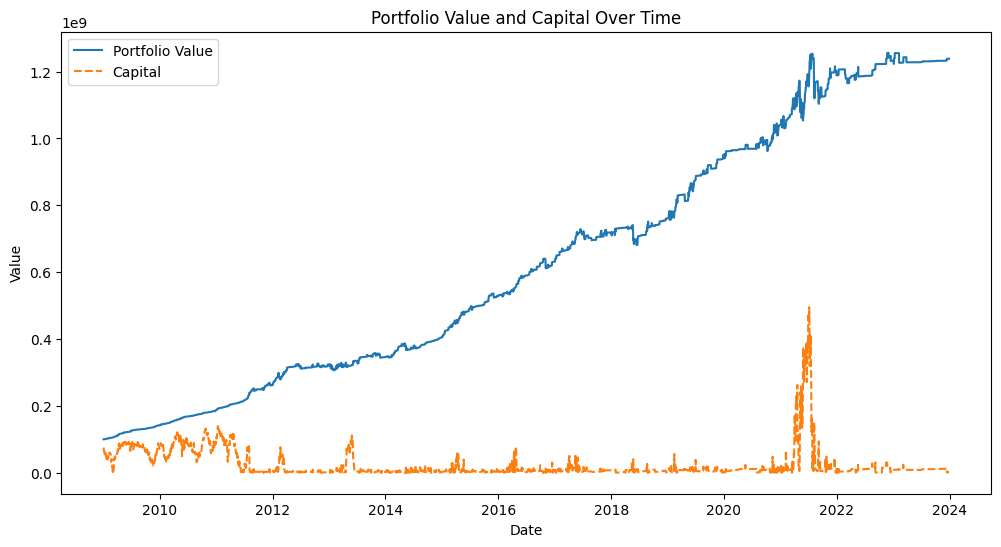

In [4]:
import numpy as np


# def visualize_results(df, portfolio_values, buy_signals, sell_signals, initial_capital):
#     fig, ax1 = plt.subplots(figsize=(14, 7))

#     # 첫 번째 y축 설정 (왼쪽)
#     ax1.set_xlabel('Time (Days)')
#     ax1.set_ylabel('Closing Price', color='skyblue')
#     ax1.plot(df.index, df['종가'], label='Closing Price', color='skyblue', alpha=0.5)
#     ax1.tick_params(axis='y', labelcolor='skyblue')
    
#     # 두 번째 y축 설정 (오른쪽)
#     ax2 = ax1.twinx()
#     ax2.set_ylabel('Portfolio Value', color='blue')
#     ax2.plot(df.index, portfolio_values, label='Portfolio Value', color='blue', alpha=0.8)
#     ax2.tick_params(axis='y', labelcolor='blue')
    
#       # 시각화 함수 내부
#     for buy in buy_signals:
#         ax1.scatter(buy[0], buy[1], color='green', marker='^', alpha=1)
    
#     for sell in sell_signals:
#         ax1.scatter(sell[0], sell[1], color='red', marker='v', alpha=1)


#     # 범례와 타이틀 설정
#     lines, labels = ax1.get_legend_handles_labels()
#     lines2, labels2 = ax2.get_legend_handles_labels()
#     ax2.legend(lines + lines2, labels + labels2, loc='upper left')
#     plt.title('Portfolio Value and Closing Price Over Time')

#     # 그래프 표시
#     plt.show()



# def main_backtesting_process(df, initial_capital, num_splits=10, buy_threshold=48):
#     positions = []
#     capital = initial_capital
#     portfolio_values = []  # 포트폴리오 가치를 저장하는 리스트
#     max_drawdowns = []  # 최대 드로다운을 저장하는 리스트
#     peak_capital = initial_capital
#     investment_per_split = initial_capital / num_splits

#     df = rolling_window_calculations(df)
    
#     for index, row in df.iterrows():
#         positions, capital = check_buy_sell_conditions(row, positions, capital, investment_per_split,num_splits, buy_threshold)
#         current_portfolio_value = update_portfolio_values(positions, capital)
#         portfolio_values.append(current_portfolio_value)

#         if current_portfolio_value > peak_capital: #자본 최대지점 찾기; MDD구하는 코딩
#             peak_capital = current_portfolio_value
#         current_drawdown = (peak_capital - current_portfolio_value) / peak_capital
#         max_drawdowns.append(current_drawdown)

#     total_days = (df.index[-1] - df.index[0]).days
#     final_capital = portfolio_values[-1]
#     total_profit , roi, cagr = calculate_final_results(initial_capital, final_capital, total_days)
#     # 총 수익, ROI, 연평균수익률
    

#     # 결과 출력
#     print("Initial Capital: ${:.2f}".format(initial_capital))
#     print("Final Capital: ${:.2f}".format(final_capital))
#     print("Total Profit: ${:.2f}".format(total_profit))
#     print("ROI: {:.2f}%".format(roi))
#     print("Max Drawdown: {:.2f}%".format(max(max_drawdowns) * 100))
#     print("CAGR: {:.2f}%".format(cagr * 100))

#     # # 최대 드로다운 그래프
#     # plt.figure(figsize=(12, 6))
#     # plt.plot(max_drawdowns, label='Max Drawdown')
#     # plt.title('Max Drawdown Over Time')
#     # plt.xlabel('Time (days)')
#     # plt.ylabel('Max Drawdown')
#     # plt.legend()
#     # plt.show()
#     # main_backtesting_process 함수 내부에서 시각화 함수 호출 부분
#     visualize_results(df, portfolio_values, buy_signals, sell_signals, initial_capital)
#     return final_capital, cagr







# 포트폴리오의 총 자본 변화, MDD, CAGR 계산
def calculate_portfolio_performance(portfolio, initial_capital):
    # print(portfolio)
    final_capital = portfolio_values_over_time[-1]
    total_profit = final_capital - initial_capital
    roi = (total_profit / initial_capital) * 100

    # MDD 계산
    peak = np.maximum.accumulate(portfolio_values_over_time)
    drawdown = (peak - portfolio_values_over_time) / peak
    mdd = np.max(drawdown) * 100

    # CAGR 계산
    total_days = (all_trading_dates[-1] - all_trading_dates[0]).days
    total_years = total_days / 365.25
    
    if final_capital > 0:
        cagr = ((final_capital / initial_capital) ** (1 / total_years)) - 1
    else:
        cagr = -1
    return final_capital, roi, mdd, cagr

def visualize_portfolio_performance(portfolio, initial_capital, portfolio_values_over_time, capital_over_time, all_trading_dates):
    final_capital, roi, mdd, cagr = calculate_portfolio_performance(portfolio, initial_capital)

    print(f"Initial Capital: ${initial_capital:,.2f}")
    print(f"Final Capital: ${final_capital:,.2f}")
    print(f"Total ROI: {roi:.2f}%")
    print(f"Max Drawdown: {mdd:.2f}%")
    print(f"CAGR: {cagr:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(all_trading_dates, portfolio_values_over_time, label='Portfolio Value')
    plt.plot(all_trading_dates, capital_over_time, label='Capital', linestyle='--')
    plt.title('Portfolio Value and Capital Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# 포트폴리오 백테스팅 결과 시각화 실행
visualize_portfolio_performance(positions_dict, initial_capital, portfolio_values_over_time, capital_over_time, all_trading_dates)



In [4]:


# from itertools import product
# import numpy as np
# def main_backtesting_process_for_opt(df, initial_capital, sell_profit_rate, num_splits=10, buy_threshold=48):
#     positions = []
#     capital = initial_capital
#     portfolio_values = []  # 포트폴리오 가치를 저장하는 리스트
#     max_drawdowns = []  # 최대 드로다운을 저장하는 리스트
#     peak_capital = initial_capital
#     investment_per_split = initial_capital / num_splits

#     df = rolling_window_calculations(df)
    
#     for index, row in df.iterrows():
#         positions, capital = check_buy_sell_conditions(row, positions, capital, investment_per_split,num_splits, buy_threshold, sell_profit_rate)
#         current_portfolio_value = update_portfolio_values(positions, capital)
#         portfolio_values.append(current_portfolio_value)

#         if current_portfolio_value > peak_capital: #자본 최대지점 찾기; MDD구하는 코딩
#             peak_capital = current_portfolio_value
#         current_drawdown = (peak_capital - current_portfolio_value) / peak_capital
#         max_drawdowns.append(current_drawdown)

#     total_days = (df.index[-1] - df.index[0]).days
#     final_capital = portfolio_values[-1]
#     total_profit , roi, cagr = calculate_final_results(initial_capital, final_capital, total_days)
#     # 총 수익, ROI, 연평균수익률
    

#     # 결과 출력
#     # print("Initial Capital: ${:.2f}".format(initial_capital))
#     # print("Final Capital: ${:.2f}".format(final_capital))
#     # print("Total Profit: ${:.2f}".format(total_profit))
#     # print("ROI: {:.2f}%".format(roi))
#     # print("Max Drawdown: {:.2f}%".format(max(max_drawdowns) * 100))
#     # print("CAGR: {:.2f}%".format(cagr * 100))

#     # # 최대 드로다운 그래프
#     # plt.figure(figsize=(12, 6))
#     # plt.plot(max_drawdowns, label='Max Drawdown')
#     # plt.title('Max Drawdown Over Time')
#     # plt.xlabel('Time (days)')
#     # plt.ylabel('Max Drawdown')
#     # plt.legend()
#     # plt.show()
#     # main_backtesting_process 함수 내부에서 시각화 함수 호출 부분
#     # visualize_results(df, portfolio_values, buy_signals, sell_signals, initial_capital)
#     return final_capital, cagr





# # Define optimization process
# def optimize_parameters(df, initial_capital, num_splits=10):
#     optimization_results = pd.DataFrame(columns=['Buy Threshold',  'Sell Rate', 'CAGR'])
#      # Separate parameter grids for integer and float parameters
#     int_param_grid = {
#         'buy_threshold': range(30, 70, 5)
#     }
    
#     float_param_grid = {
#         # 'additional_buy_drop_rate':  np.arange(1, 8.6, 0.5),
#         'sell_profit_rate':   np.arange(1, 15, 0.5)
#     }
#      # Combine integer and float parameter grids
#     param_grid = {**int_param_grid, **float_param_grid}
    
#     for buy_threshold, sell_rate in product(*param_grid.values()):
#         # Reset the signals for each run
#         buy_signals = []
#         sell_signals = []
#         # Run the backtesting process with the current parameters
#         final_capital, cagr = main_backtesting_process_for_opt(
#             df, initial_capital, sell_rate, num_splits,   buy_threshold   )

#         # Append the results to the dataframe
#        # 대신 이렇게 수정합니다:
#         optimization_results = pd.concat([optimization_results, pd.DataFrame([{
#             'Buy Threshold': buy_threshold,
#             'Sell Rate': sell_rate,
#             'CAGR': cagr
#         }])], ignore_index=True)
#         # print(buy_threshold, drop_rate, sell_rate)
#     # Sort the results by CAGR in descending order to find the best parameters
#     optimization_results.sort_values('CAGR', ascending=False, inplace=True)
    
#     # Return the top 10 parameters
#     top_parameters = optimization_results.head(10)
#     return top_parameters




In [5]:
# buy_signals = []
# sell_signals = []    

#  # 사용자가 변경할 수 있는 매수 진입 점수 임계값
# # Load data and run backtesting
# df = pd.read_excel('./korea_stock/136540.xlsx')
# df.set_index('날짜', inplace=True)
# main_backtesting_process(df, 10000000,8.5,10,55)


In [6]:
# buy_signals = []
# sell_signals = []
# # Load data
# df = pd.read_excel('./korea_stock/136540.xlsx')
# df.set_index('날짜', inplace=True)
# # Optimize parameters
# initial_capital = 10000000
# # Now call the optimization function
# top_parameters = optimize_parameters(df, initial_capital, num_splits=10)

# # Print out the best parameters
# print("Best parameters for maximized CAGR:")
# print(top_parameters)